In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time

In [2]:
TRAINING_DIR = "brain_tumor_dataset/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=1, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "brain_tumor_dataset/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=1, 
                                                         target_size=(150, 150))
#work on progress
 

Found 220 images belonging to 2 classes.
Found 33 images belonging to 2 classes.


In [3]:
CATEGORIES = ['no','yes']

IMG_SIZE = 150
train_data = []

for c in CATEGORIES:
    path = os.path.join(TRAINING_DIR, c)
    class_num = CATEGORIES.index(c)

    for img in  tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            train_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(train_data))

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:01<00:00, 86.62it/s]

220


In [4]:
CATEGORIES = ['no','yes']

IMG_SIZE = 150
test_data = []

for c in CATEGORIES:
    path = os.path.join(VALIDATION_DIR, c)
    class_num = CATEGORIES.index(c)

    for img in  tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.63it/s]

33


In [5]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (33, 150, 150, 3) Y_test= (33,)


In [6]:
X_train = []
Y_train = []

for features,label in train_data:
    X_train.append(features)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (220, 150, 150, 3) Y_train= (220,)


In [7]:
X_train, X_test = X_train / 255.0, X_test / 255.0

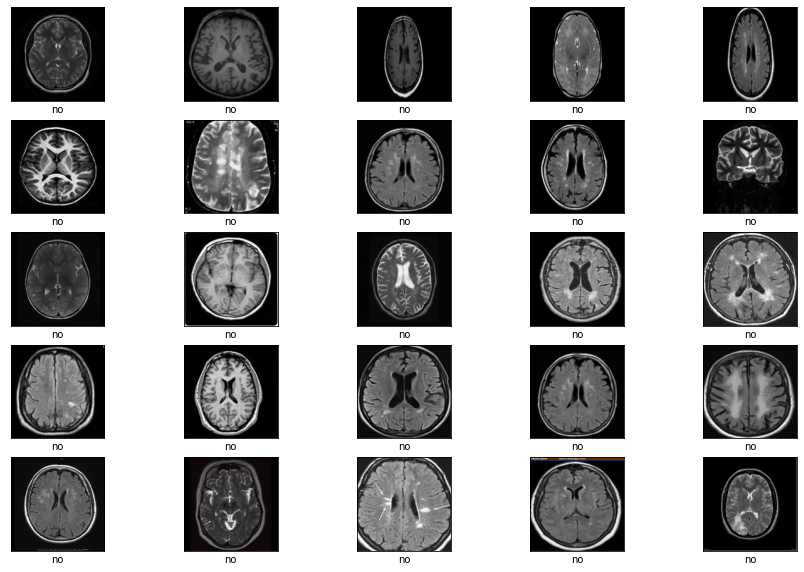

In [8]:
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_data[i][0])
    plt.xlabel(CATEGORIES[train_data[i][1]])

plt.show()


In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    Activation('relu'),
    Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    Activation('relu'),
    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    

    Flatten(),

    
    Dense(units=1024),
    Activation('relu'),
    Dropout(0.2),
    

    Dense(2),
    Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 128)       0

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [11]:
try:
    history = model.fit_generator(train_generator,epochs=5,validation_data=validation_generator)
except Exception as e:
    print(e)

E:\CVPR\envs\cvpr\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
220/220 [==============================] - 286s 1s/step - loss: 0.8819 - acc: 0.6409 - val_loss: 0.8232 - val_acc: 0.4545
Epoch 2/5
220/220 [==============================] - 309s 1s/step - loss: 0.6552 - acc: 0.6273 - val_loss: 0.6972 - val_acc: 0.4545
Epoch 3/5
220/220 [==============================] - 289s 1s/step - loss: 0.6698 - acc: 0.6682 - val_loss: 0.6651 - val_acc: 0.7576
Epoch 4/5
220/220 [==============================] - 292s 1s/step - loss: 0.6420 - acc: 0.6318 - val_loss: 0.6701 - val_acc: 0.4545
Epoch 5/5
220/220 [==============================] - 290s 1s/step - loss: 0.7464 - acc: 0.6318 - val_loss: 0.7027 - val_acc: 0.4545


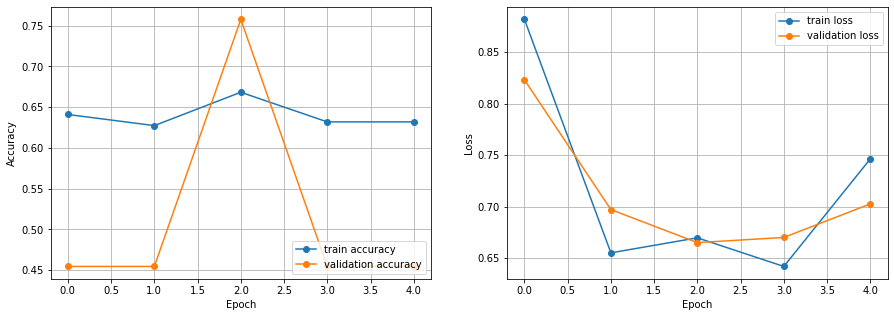

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], 'o-', label='train accuracy')
plt.plot(history.history['val_acc'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [14]:
model.save('tumor_model.h5')

In [15]:
Test_DIR = "brain_tumor_dataset/aaa"
CATEGORIES = ['no','yes']

IMG_SIZE = 150
aaa_data = []

for c in CATEGORIES:
    path = os.path.join(Test_DIR, c)
    class_num = CATEGORIES.index(c)

    for img in  tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            aaa_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(aaa_data))

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 119.09it/s]

7


In [16]:
X_aaa = []
Y_aaa= []

for features,label in aaa_data:
    X_aaa.append(features)
    Y_aaa.append(label)

X_aaa = np.array(X_aaa).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_aaa = np.array(Y_aaa)

print(f"X_test= {X_aaa.shape} Y_test= {Y_aaa.shape}")

X_test= (7, 150, 150, 3) Y_test= (7,)


In [17]:
X_aaa = X_aaa / 255.0

In [18]:
predictions = model.predict(X_aaa)

In [28]:
predictions[0]

array([0.42550644, 0.5744936 ], dtype=float32)

In [26]:
np.argmax(predictions[0])


1

In [21]:
print(Y_aaa[0])


0


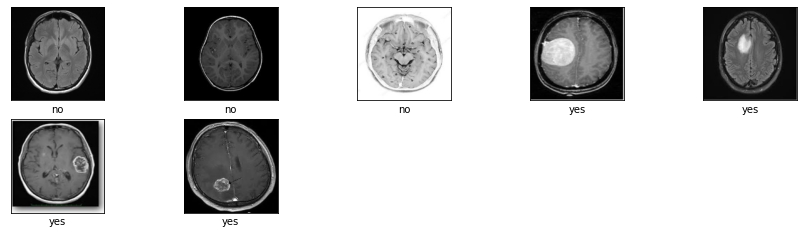

In [22]:
plt.figure(figsize=(15,10))
for i in range(7):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(aaa_data[i][0])
    plt.xlabel(CATEGORIES[aaa_data[i][1]])

plt.show()

In [24]:
print (CATEGORIES[0])

no


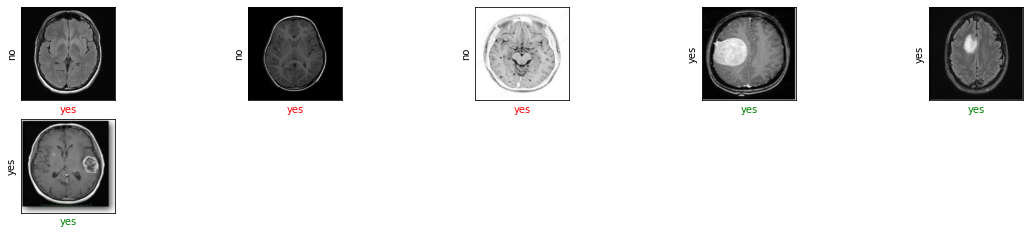

In [25]:
rows = 5
cols = 5

plt.figure(figsize=(20,10))
for i in range(6):
    
    plt.subplot(rows, 2*cols, 2*i+1)
    plt.imshow(X_aaa[i])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(CATEGORIES[Y_aaa[i]])
    if Y_aaa[i] == np.argmax(predictions[i]):
        
        plt.xlabel(CATEGORIES[np.argmax(predictions[i])], color='g')
    else:
        plt.xlabel(CATEGORIES[np.argmax(predictions[i])], color='r')
        
   
   
plt.show()